**Data Used:** https://storage.googleapis.com/openimages/web/visualizer/index.html?type=segmentation&set=train&r=false&c=%2Fm%2F01yrx

### **Step 1: Install Libraries & Download Data**

This cell installs the necessary dependencies (`ultralytics` for YOLOv8 and `fiftyone` for dataset management). It then downloads a specific subset of the Open Images V7 dataset containing only "Owl" images with segmentation masks.

**Important Notes:**

- **`max_samples`:** We limit the download to 300 training and 50 validation images to ensure the notebook runs quickly in the free Colab tier. Increase this for better accuracy.
    
- **`label_types=["segmentations"]`:** This ensures we only download images that have pixel-level masks, not just bounding boxes.
    

In [1]:
# Install necessary libraries
!pip install ultralytics fiftyone -q
!pip install opencv-python-headless -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.5/934.5 kB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.8 MB/s eta 0:00:

In [2]:
import fiftyone as fo
import fiftyone.zoo as foz
import cv2
import numpy as np
import os
import shutil
import yaml
from ultralytics import YOLO
from tqdm import tqdm

/usr/local/lib/python3.12/dist-packages/glob2/fnmatch.py:141: SyntaxWarning: invalid escape sequence '\Z'
  return '(?ms)' + res + '\Z'


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# SETUP & CLEANUP

In [3]:
project_dir = "/content/cat_project"
images_dir = os.path.join(project_dir, "images")
masks_dir = os.path.join(project_dir, "masks")
labels_dir = os.path.join(project_dir, "labels")

# Wipe clean to ensure a fresh start
if os.path.exists(project_dir): shutil.rmtree(project_dir)
os.makedirs(images_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# Delete FiftyOne database memory to prevent "broken dataset" errors
if fo.dataset_exists("cat-segmentation"):
    fo.delete_dataset("cat-segmentation")

# DOWNLOAD DATA (CATS)


In [4]:
print("⬇️ Downloading Cat Data...")

# We use the config we KNOW works (detections + segmentations)
dataset = foz.load_zoo_dataset(
    "open-images-v7",
    split="train",
    label_types=["detections", "segmentations"],
    classes=["Cat"],
    max_samples=1500,
    only_matching=True,
    dataset_name="cat-segmentation"
)

⬇️ Downloading Cat Data...


INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/open-images-v7/train' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv' to '/root/fiftyone/open-images-v7/train/metadata/image_ids.csv'


 100% |██████|    4.8Gb/4.8Gb [27.7s elapsed, 0s remaining, 187.6Mb/s]      


INFO:eta.core.utils: 100% |██████|    4.8Gb/4.8Gb [27.7s elapsed, 0s remaining, 187.6Mb/s]      


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/root/fiftyone/open-images-v7/train/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/classes-segmentation.txt' to '/root/fiftyone/open-images-v7/train/metadata/segmentation_classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmprliw59pw/metadata/hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-bbox.csv' to '/root/fiftyone/open-images-v7/train/labels/detections.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-annotations-object-segmentation.csv' to '/root/fiftyone/open-images-v7/train/labels/segmentations.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-1.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/1.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-0.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/0.zip'


INFO:fiftyone.utils.openimages:Downloading 1500 images


 100% |█████████████████| 1500/1500 [7.3m elapsed, 0s remaining, 2.8 files/s]      


INFO:eta.core.utils: 100% |█████████████████| 1500/1500 [7.3m elapsed, 0s remaining, 2.8 files/s]      


Dataset info written to '/root/fiftyone/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v7/info.json'


Loading 'open-images-v7' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'train'


 100% |███████████████| 1500/1500 [54.6s elapsed, 0s remaining, 29.9 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1500/1500 [54.6s elapsed, 0s remaining, 29.9 samples/s]      


Dataset 'cat-segmentation' created


INFO:fiftyone.zoo.datasets:Dataset 'cat-segmentation' created


MANUAL MASK GENERATION (The "Repo" Requirement)

In [5]:
print("🎨 Generating Binary Masks (Repo Style)...")

valid_count = 0

for sample in tqdm(dataset, desc="Generating PNGs"):
    img_path = sample.filepath

    # 1. Load Image
    img = cv2.imread(img_path)
    if img is None: continue
    h, w = img.shape[:2]

    # 2. Create Blank Black Mask
    full_mask = np.zeros((h, w), dtype=np.uint8)
    has_cat = False

    # 3. Paint "Cat" masks onto the black canvas
    if sample.segmentations:
        for det in sample.segmentations.detections:
            if det.label == "Cat" and det.mask is not None:
                has_cat = True

                # FiftyOne masks are small patches inside the bounding box
                mask_patch = det.mask

                # Get coordinates
                box = det.bounding_box # [x, y, w, h] normalized
                x1 = int(box[0] * w)
                y1 = int(box[1] * h)
                w_box = int(box[2] * w)
                h_box = int(box[3] * h)

                # Resize mask patch to fit the box
                mask_resized = cv2.resize(
                    mask_patch.astype(np.uint8),
                    (w_box, h_box),
                    interpolation=cv2.INTER_NEAREST
                )

                # Calculate placement (handling clipping at edges)
                y2 = min(y1 + h_box, h)
                x2 = min(x1 + w_box, w)
                patch_h = y2 - y1
                patch_w = x2 - x1

                # Paste the mask (Logical OR to combine overlapping cats)
                if patch_h > 0 and patch_w > 0:
                     full_mask[y1:y2, x1:x2] = cv2.bitwise_or(
                         full_mask[y1:y2, x1:x2],
                         mask_resized[:patch_h, :patch_w] * 255
                     )

    # 4. Save (Only if we found a cat)
    if has_cat:
        file_id = os.path.basename(img_path).replace(".jpg", "")
        shutil.copy(img_path, os.path.join(images_dir, f"{file_id}.jpg"))
        cv2.imwrite(os.path.join(masks_dir, f"{file_id}.png"), full_mask)
        valid_count += 1

print(f"✅ Generated {valid_count} valid images/masks.")

🎨 Generating Binary Masks (Repo Style)...


Generating PNGs: 100%|██████████| 1500/1500 [00:22<00:00, 67.50it/s]

✅ Generated 1500 valid images/masks.


### **Step 2: Convert Masks to YOLO Polygons (Core Logic)**

This is the most critical part of the pipeline. Open Images provides binary mask images (PNGs), but YOLOv8 requires text files containing normalized polygon coordinates. This script iterates through the downloaded data, extracts contours from the masks using OpenCV, and saves them in the correct YOLO format.

**Important Notes:**

- **The Fix:** This version includes the `if not sample.has_field("segmentations")` check to prevent the `AttributeError` you encountered earlier.
    
- **Empty Labels:** If an image has no valid segmentations, it creates an empty `.txt` file. This is crucial—without it, the training loop might crash or ignore those images incorrectly.
    
- **Normalization:** Coordinates are converted to a 0-1 range (`x / width`, `y / height`), which is required by YOLO.
    

In [6]:
print("🔄 Converting to YOLO Format...")

mask_files = [f for f in os.listdir(masks_dir) if f.endswith('.png')]

for mask_file in tqdm(mask_files, desc="Converting"):
    file_id = mask_file.replace(".png", "")
    mask_path = os.path.join(masks_dir, mask_file)
    label_path = os.path.join(labels_dir, f"{file_id}.txt")

    # Load & Threshold
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Find Contours
    H, W = mask.shape
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    polygons = []
    for cnt in contours:
        # 🛑 REPO LOGIC: Ignore small noise (Area < 200)
        if cv2.contourArea(cnt) > 200:
            polygon = []
            for point in cnt:
                x, y = point[0]
                polygon.append(x / W)
                polygon.append(y / H)

            # "0" = Cat
            poly_str = "0 " + " ".join(map(str, polygon))
            polygons.append(poly_str)

    if polygons:
        with open(label_path, "w") as f:
            f.write("\n".join(polygons))

🔄 Converting to YOLO Format...


Converting: 100%|██████████| 1500/1500 [00:09<00:00, 163.23it/s]


### **Step 3: Train YOLOv8-Seg Model**

This cell loads the pre-trained "Nano" segmentation model (`yolov8n-seg.pt`) and fine-tunes it on our custom Owl dataset.

**Important Notes:**

- **Model Choice:** `yolov8n-seg.pt` is the smallest and fastest model, perfect for Colab testing. For higher accuracy in production, you might switch to `yolov8s-seg.pt` or `yolov8m-seg.pt`.
    
- **Epochs:** Set to `20` for a quick demonstration. For a production-grade model, you typically want 50–100 epochs.
    

In [7]:
print("🚀 Starting Training...")

# Create YAML
with open(f"{project_dir}/dataset.yaml", "w") as f:
    f.write(f"path: {project_dir}\ntrain: images\nval: images\nnames:\n  0: Cat")

# Train
model = YOLO('yolov8s-seg.pt')

results = model.train(
    data=f"{project_dir}/dataset.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    name='cat_segmentation_model',
    overlap_mask=True,
    single_cls=True,
    save=True
)

print("✅ SUCCESS! Cat model trained.")

🚀 Starting Training...
Ultralytics 8.4.11 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/cat_project/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=cat_segmentation_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=aut

### **Step 4: Run Inference & Visualize Results**

After training, this cell picks a random image from the validation set and runs the new model on it to verify that it correctly segments owls.

**Important Notes:**

- **Dynamic Path Finding:** The script uses `glob` to automatically find the latest training run folder (`runs/segment/...`), so you don't have to manually update the path if you re-train the model multiple times.
    

🧠 Loading model from: /content/runs/segment/cat_segmentation_model/weights/best.pt
📸 Testing on image: 0a2cf4d8fb3df557.jpg
Results saved to /content/inference_vis/result

👇 Here is the segmentation result:


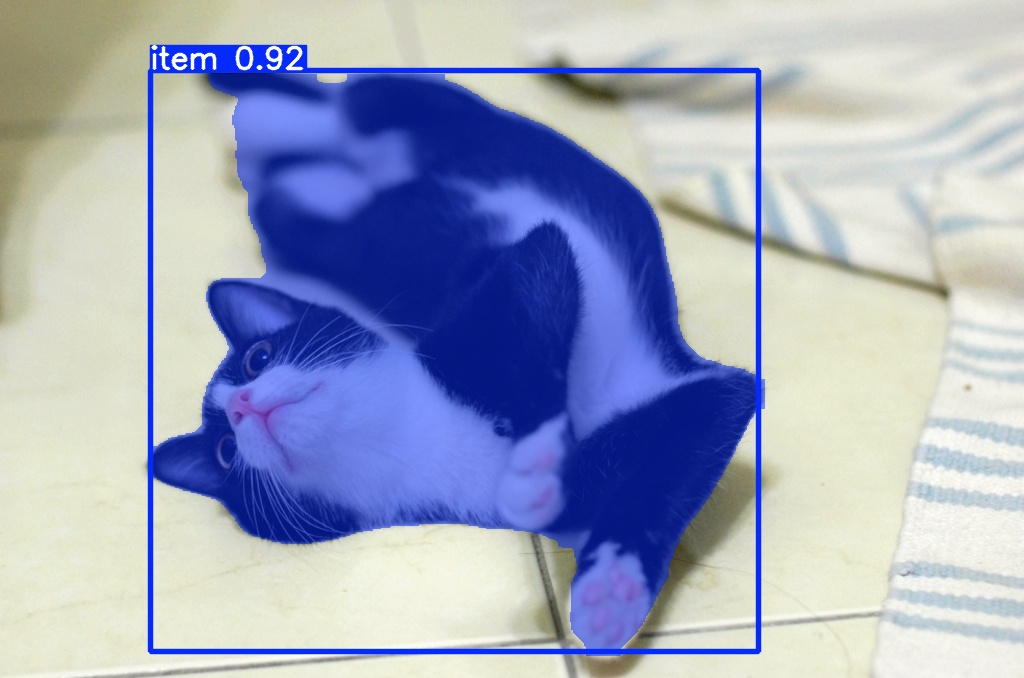

In [8]:
import os
import random
import glob
from ultralytics import YOLO
from IPython.display import Image, display

# =================================================================
# 1. SETUP PATHS
# =================================================================
# This points to the model you just trained
# (If you ran training multiple times, it might be cat_segmentation_model2, etc.)
# We use a glob search to find the LATEST run automatically.
search_pattern = '/content/runs/segment/*/weights/best.pt'
found_models = sorted(glob.glob(search_pattern), key=os.path.getmtime)

if not found_models:
    raise FileNotFoundError("❌ No trained model found! Did the training step finish?")

best_model_path = found_models[-1] # Pick the most recent one
print(f"🧠 Loading model from: {best_model_path}")

# Point to where we saved our cat images
test_images_dir = "/content/cat_project/images"

# =================================================================
# 2. RUN INFERENCE & VISUALIZE
# =================================================================
model = YOLO(best_model_path)

# Pick a random image to test
jpg_files = glob.glob(os.path.join(test_images_dir, "*.jpg"))

if len(jpg_files) > 0:
    random_file = random.choice(jpg_files)
    print(f"📸 Testing on image: {os.path.basename(random_file)}")

    # Run Prediction
    # save=True writes the output image with the mask overlay to disk
    results = model.predict(
        source=random_file,
        save=True,
        project="/content/inference_vis",
        name="result",
        exist_ok=True,
        verbose=False
    )

    # Display the saved image
    # YOLO saves it inside the 'project/name' folder
    save_dir = results[0].save_dir
    result_image_path = os.path.join(save_dir, os.path.basename(random_file))

    print("\n👇 Here is the segmentation result:")
    display(Image(filename=result_image_path, width=600))

else:
    print("⚠️ No images found in /content/cat_project/images to test on.")

# Download the modeol

In [9]:
from google.colab import files
import glob
import os

# Find the most recently trained model
search_pattern = '/content/runs/segment/*/weights/best.pt'
found_models = sorted(glob.glob(search_pattern), key=os.path.getmtime)

if found_models:
    best_model = found_models[-1]
    print(f"⬇️ Downloading: {best_model}")
    files.download(best_model)
else:
    print("❌ Could not find a best.pt file. Check your 'runs' folder.")

⬇️ Downloading: /content/runs/segment/cat_segmentation_model/weights/best.pt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>